In [ ]:
!pip install kaggle

In [ ]:
# the imports
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn import feature_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [ ]:
# upload kaggle.json (kaggle creds file) for the kaggle api
files.upload()

In [ ]:
# make, copy, set permissions, download, unzip
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

In [ ]:
# to pandas
data_desc = pd.read_fwf('data_description.txt')
data_samp_sub = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
def clean_data(data):
  """
  Sifting, sorting, feature engineering, the good stuff....
  :param data: The pandas DataFrame being manipulated for this specific problem
  """
  # dropping Year Built as year remodeled contains latest year worked on (almost the same data and correlation)
  data.drop('YearBuilt', axis=1, inplace=True)
  # dropping poolqa as no obvious (strong) correlation
  data.drop('PoolQC',axis=1,inplace=True)
  data['PoolArea'] = np.where(data['PoolArea'] > 0,1,0)
  # one hot encode (dummies) Street into pave or grvl, might want to switch to bool
  data = pd.concat([data.drop('Street',axis=1),pd.get_dummies(data['Street'],drop_first=True)],axis=1)
  # same to MSZoning
  data = pd.concat([data.drop('MSZoning',axis=1),pd.get_dummies(data['MSZoning'],drop_first=True)],axis=1)
  # I believe paved allys would likely be in less rural areas. Cities can have paved allys in poor or better neighboorhoods. Using one hot might weigh model toward paved when places have none as well.
  data = data.drop('Alley',axis=1)
  # LandContour and LotShape have similar BoxPlots and may be correlated. LotShape also seems more opinionated. Doing one hot on LandContour and dropping LotShape
  data = pd.concat([data.drop('LandContour',axis=1),pd.get_dummies(data['LandContour'],drop_first=True)],axis=1)
  data = data.drop('LotShape',axis=1)
  # one hot bothe LotConfig and LandSlope
  data = pd.concat([data.drop('LotConfig',axis=1),pd.get_dummies(data['LotConfig'],drop_first=True)],axis=1)
  data = pd.concat([data.drop('LandSlope',axis=1),pd.get_dummies(data['LandSlope'],drop_first=True)],axis=1)
  # dropping feature desciption and keeping value, value should be indicative without the item class for regression. Also, The shed has a wide range of added value.
  data.drop('MiscFeature',axis=1,inplace=True)
  # switching BldgType to two categories, single family or not
  data['BldgCatSingle'] = np.where(data['BldgType'] == '1Fam',1,0)
  # drop bldgType now that BldgCatSingle available
  data.drop('BldgType',axis=1,inplace=True)
  # drop HouseStyle and MSSubClass as we get this info from other columns
  data.drop('HouseStyle',axis=1,inplace=True)
  data.drop('MSSubClass',axis=1,inplace=True)
  # dropping lot area as city vs rural land costs would likely skew results
  data.drop('LotArea',axis=1,inplace=True)
  # dropping Utilities as this seems primarily be sampling of city with municiplal, no as unique
  data.drop('Utilities',axis=1,inplace=True)
  # Neighborhood one hot
  data = pd.concat([data.drop('Neighborhood',axis=1),pd.get_dummies(data['Neighborhood'],drop_first=True)],axis=1)
  # dropping second condition and making first condition a bool
  data.drop('Condition2',axis=1,inplace=True)
  data['Condition1'] = np.where(data['Condition1'] == 'Norm',1,0)
  # OverallQual one hot
  data = pd.concat([data.drop('OverallQual',axis=1),pd.get_dummies(data['OverallQual'],drop_first=True)],axis=1)
  # overall condition being dropped subjective, also bulk ranges from 5-8
  data.drop('OverallCond',axis=1,inplace=True)
  # RoofMatl drop as not test data missing categories
  data.drop('RoofMatl',axis=1,inplace=True)
  # Roof style does not seem as correlative dropping
  data.drop('RoofStyle',axis=1,inplace=True)
  # siding might be wrong, both 1st and 2nd list shingles (roofing) as a type of common siding. Dropping them.
  data.drop(['Exterior1st','Exterior2nd'],axis=1,inplace=True)
  # not correlating to sale price visually
  data.drop('MasVnrArea',axis=1,inplace=True)
  # type to one hot
  data = pd.concat([data.drop('MasVnrType',axis=1),pd.get_dummies(data['MasVnrType'],drop_first=True)],axis=1)
  # ExterCond does not seem coralative and potentially subjective
  data.drop('ExterCond',axis=1,inplace=True)
  # Qual seems more correlative
  data = pd.concat([data.drop('ExterQual',axis=1),pd.get_dummies(data['ExterQual'],drop_first=True)],axis=1)
  # foundation seems non-correlative
  data.drop('Foundation',axis=1,inplace=True)
  # replacing nan with not applicable
  data['BsmtCond'] = data['BsmtCond'].replace(np.nan, 'NA')
  # basment condition to one hot
  data = pd.concat([data.drop('BsmtCond',axis=1),pd.get_dummies(data['BsmtCond'],drop_first=True)],axis=1)
  # BsmtExposure replace nan with not applicable
  data['BsmtExposure'] = data['BsmtExposure'].replace(np.nan, 'NA')
  # drop features that don't look correlative
  data.drop(['BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1',
                    'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'],axis=1,inplace=True)
  # drop feature that does not seem correlative
  data.drop(['SaleType','SaleCondition'],axis=1,inplace=True)
  # drop feature that does not seem correlative (this data set does have noticable mean differences
  data.drop(['MoSold','YrSold'],axis=1,inplace=True)
  # replace nan
  data['Fence'] = data['Fence'].replace(np.nan,'None')
  # switch to bool
  data['Fence'] = np.where(data['Fence'] == 'None',1,0)
  # type with gas in name correlated to much higher prices
  data['Heating'] = np.where(data['Heating'].str.contains('Gas', regex=True),1,0)
  # switch category to bool
  data['CentralAir'] = np.where(data['CentralAir'] == 'Y',1,0)
  # subjective and not highly correlative
  data.drop('HeatingQC',axis=1,inplace=True)
  # switch categorical to standard breaker or not bool
  data['Electrical'] = np.where(data['Electrical'] == 'SBrkr',1,0)
  # switch to bool inplace of numerical grade
  data['LowQualFinSF'] = np.where(data['LowQualFinSF'] > 0,0,1)
  # utilize count of baths and drop bath features
  data['BathCount'] = (data['BsmtFullBath'] + data['FullBath']) + (data['BsmtHalfBath'] + data['HalfBath'] *.5)
  # ensure no nans
  data['BathCount'] = np.nan_to_num(data['BathCount'])
  data.drop(['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath'],axis=1,inplace=True)
  # drop above grades as not full count and not obviously correlative
  data.drop(['BedroomAbvGr','KitchenAbvGr'],axis=1,inplace=True)
  # kitchen qual to one hot
  data = pd.concat([data.drop('KitchenQual',axis=1),pd.get_dummies(data['KitchenQual'],drop_first=True)],axis=1)
  # drop as not obviously correlative
  data.drop(['Functional'],axis=1,inplace=True)
  # switch count to bool
  data['Fireplaces'] = np.where(data['Fireplaces'] > 0,1,0)
  # switch categorical to bool
  data['FireplaceQu'] = np.where(data['FireplaceQu'] == 'Ex',1,0)
  # various garage items not highly correlative
  data.drop(['GarageType','GarageYrBlt','GarageFinish','GarageArea','GarageQual','GarageCond'],axis=1,inplace=True)
  # switch form categorical to bool
  data['PavedDrive'] = np.where(data['PavedDrive'] == 'Y',1,0)
  # drop various features deemed uncorrelative or unimportant
  data.drop('WoodDeckSF',axis=1,inplace=True)
  data.drop('OpenPorchSF',axis=1,inplace=True)
  data.drop('EnclosedPorch',axis=1,inplace=True)
  data.drop('3SsnPorch',axis=1,inplace=True)
  data.drop('ScreenPorch',axis=1,inplace=True)
  data.drop('LotFrontage',axis=1,inplace=True)
  return data

In [ ]:
# update test and train with the feature engineering changes
train = clean_data(train)
test = clean_data(test)
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

In [ ]:
# split, scale, set early stopping
labels = train['SalePrice']
features = train.drop('SalePrice',axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience=25)

In [ ]:
# sequential ann model set for linear with mse loss
model = Sequential()
model.add(Dense(100,activation='relu'))
#model.add(Dropout(rate=.7))
model.add(Dense(75,activation='relu'))
#model.add(Dropout(rate=.6))
model.add(Dense(50,activation='relu'))
#model.add(Dropout(rate=.5))
model.add(Dense(25,activation='relu'))
#model.add(Dropout(rate=.4))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam')

In [ ]:
# fit the model to the test data
hist = model.fit(x=X_train,y=y_train,epochs=500, validation_data=(X_test,y_test),callbacks=[early_stop])

In [ ]:
# mount and save model if wanted, I utilized Colab notebooks for this
model.save('./drive/MyDrive/Colab_Notebooks/adv_reg_model_1.keras')

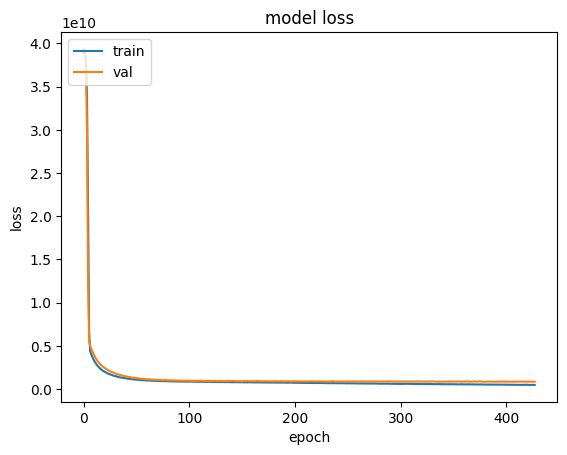

In [ ]:
# Plot the loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# checking X_test output
z = model.predict(X_test)
print(z[0])

14/14 [==============================] - 0s 1ms/step
[139314.53]


In [ ]:
# scale the test
test = scaler.transform(test)

In [ ]:
b = model.predict(test)

In [ ]:
data_samp_sub['SalePrice'] = b

In [ ]:
data_samp_sub

In [ ]:
data_samp_sub.to_csv('submission.csv',index=False)

In [ ]:
# My first submission!!!!!
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "First ann try"

100% 21.2k/21.2k [00:02<00:00, 7.97kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques